In [1]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
# importing some libraries
import pyspark
from pyspark.sql import SQLContext, SparkSession
import os
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF# stuff we'll need for building the model

from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel# reading the data
data = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/fanfics_raw.csv"))

22/04/13 07:29:21 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/04/13 07:29:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/13 07:29:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/13 07:29:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
classics = data.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = classics                                                  \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

In [4]:
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=10000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [5]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [6]:
result_cv

DataFrame[list_of_words: array<string>, index: bigint, raw_features: vector]

In [7]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/13 07:29:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/13 07:29:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [8]:
lda_model.vocabSize()

5000

In [9]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[24, 38, 44, 32, ...|[0.01769601232806...|
|    1|[5, 11, 10, 16, 4...|[0.03012255102298...|
|    2|[25, 95, 134, 51,...|[0.01822858241669...|
|    3|[3, 27, 17, 56, 5...|[0.04479754018732...|
|    4|[39, 53, 73, 97, ...|[0.02238136478162...|
|    5|[14, 26, 63, 101,...|[0.02691002923392...|
|    6|[2, 12, 66, 61, 5...|[0.03346627329011...|
|    7|[0, 20, 22, 82, 6...|[0.07240854418078...|
|    8|[37, 15, 40, 65, ...|[0.02094538570332...|
|    9|[29, 33, 21, 71, ...|[0.02544563502688...|
+-----+--------------------+--------------------+



/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [10]:
lda_model.topicsMatrix()

DenseMatrix(5000, 10, [12.4932, 1200.5274, 285.2085, 0.219, 423.7228, 249.6859, 657.3516, 155.7656, ..., 0.1606, 0.1389, 0.1392, 0.1608, 0.1599, 29.4494, 0.1584, 0.1558], 0)

In [11]:
vocabulary = cvmodel.vocabulary

In [12]:
topics_model = lda_model.describeTopics()

In [13]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

In [14]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[24, 38, 44, 32, ...|[0.01769601232806...|[susie, though, t...|
|    1|[5, 11, 10, 16, 4...|[0.03012255102298...|[know, think, qui...|
|    2|[25, 95, 134, 51,...|[0.01822858241669...|[rose, smile, pla...|
|    3|[3, 27, 17, 56, 5...|[0.04479754018732...|[says, good, rach...|
|    4|[39, 53, 73, 97, ...|[0.02238136478162...|[well, tell, miss...|
|    5|[14, 26, 63, 101,...|[0.02691002923392...|[really, take, ne...|
|    6|[2, 12, 66, 61, 5...|[0.03346627329011...|[like, going, ano...|
|    7|[0, 20, 22, 82, 6...|[0.07240854418078...|[said, elizabeth,...|
|    8|[37, 15, 40, 65, ...|[0.02094538570332...|[noelle, little, ...|
|    9|[29, 33, 21, 71, ...|[0.02544563502688...|[right, looking, ...|
+-----+--------------------+--------------------+--------------------+



In [15]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[24, 38, 44, 32, ...|[0.01769601232806...|susie though thou...|
|    1|[5, 11, 10, 16, 4...|[0.03012255102298...|know think quinn ...|
|    2|[25, 95, 134, 51,...|[0.01822858241669...|rose smile place ...|
|    3|[3, 27, 17, 56, 5...|[0.04479754018732...|says good rachel ...|
|    4|[39, 53, 73, 97, ...|[0.02238136478162...|well tell miss fe...|
|    5|[14, 26, 63, 101,...|[0.02691002923392...|really take next ...|
|    6|[2, 12, 66, 61, 5...|[0.03346627329011...|like going anothe...|
|    7|[0, 20, 22, 82, 6...|[0.07240854418078...|said elizabeth da...|
|    8|[37, 15, 40, 65, ...|[0.02094538570332...|noelle little com...|
|    9|[29, 33, 21, 71, ...|[0.02544563502688...|right looking aro...|
+-----+--------------------+--------------------+--------------------+



In [16]:
counts = lda_topics_mapped.withColumn('word', f.explode(f.split(f.col('topic_desc'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=True)

In [17]:
counts.show()

+---------+-----+
|     word|count|
+---------+-----+
|     sure|    1|
|    chloe|    1|
|   looked|    1|
|     knew|    1|
|  thought|    1|
|    susie|    1|
|     lady|    1|
|    would|    1|
|   though|    1|
|    first|    1|
|     beca|    1|
|     mean|    1|
|     want|    1|
|    thank|    1|
|  getting|    1|
|     need|    1|
|    quinn|    1|
|something|    1|
|    think|    1|
|     know|    1|
+---------+-----+
only showing top 20 rows



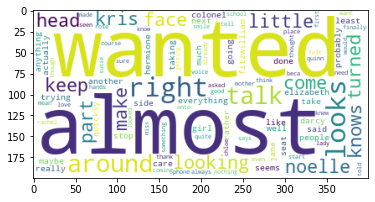

In [18]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*counts.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()
